In [106]:
%load_ext autoreload
%autoreload 2


import os
import pymysql
import pandas as pd
from dotenv import load_dotenv, find_dotenv



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
env_path = find_dotenv()
load_dotenv(env_path)
#print(os.getenv('HOST'))
#print(os.getenv('USER_DB'))

True

In [108]:
# access to the data
conn = pymysql.connect(
    host=os.getenv('HOST'),
    port=int(3306),
    user=os.getenv('USER_DB'),
    passwd=os.getenv('PASSWORD_DB'),
    db=os.getenv('DB'),
    charset='utf8mb4')



## Easy features

-Resources added to queue

-Resources completed from queue

-Ratio of resources added to queue to completed

-Minutes learned per year



The first three is in the queue.py file. The last is in the time_learning.py

In [4]:
df_trk = pd.read_sql_query("SELECT * FROM tracking_event;", conn).drop_duplicates()
df_res = pd.read_sql_query("SELECT * FROM resource;", conn).drop_duplicates()

df_trk_copy=df_trk.copy()
df_res_copy=df_res.copy()

/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [9]:
import numpy as np
# clean track_event

# reorder the dataframe according to the userID and eventDate
df_trk=df_trk_copy
df_trk.isna().sum()/len(df_trk) #content & skipMigration have over 80% missing values, delete these columns. And drop eventID
df_trk=df_trk.iloc[1:,:-2]
#df_trk['eventType'].apply(lambda)


# reorder 
df_trk=df_trk.sort_values(by=['userID','eventDate'],ascending=[True,True]).reset_index(drop=True)
df_trk
#-------------------------------------------------------------------------------------------

# return a dataframe with userID, eventType, source,eventDate, resourceType and action
# Get queueing status (returns 1 if completed from queue)
df_trk['resourceType']=df_trk['eventType'].apply(lambda x: x.split('_')[0])
df_trk['action']=df_trk['eventType'].apply(lambda x: x.split('_')[1])
df_trk.head(20)

# Get CompletionFromQueue (returns 1 if completed from the queue)


# Get mins learned per year(make this in a different py)



#Get resourceID and source
df_src=df_trk_copy[['resourceID','source']].drop_duplicates()
# create a dataframe with userID, numOfResourcesToQueue, numOfCompletionFromQueue, RatioOfCompletion_num, minOfResourcesToQueue, minOfCompletedFromQueue, RatioOfCompletion_min
# create "isQueued" columns, returns 1 if Queued
df_trk['isQueued']=df_trk['action'].map({'queued':1}).fillna(0).astype(int)
# create "isCompleted" columns, returns 1 if Completed
df_trk['isCompleted']=df_trk['action'].map({'completed':1, 'documented':1}).fillna(0).astype(int)

df_trk=df_trk.groupby(['userID','resourceID']).sum().reset_index()
# Get CompletionFromQueue (returns 1 if completed from the queue)
df_trk['CompletedFromQueue']=((df_trk['isQueued']==1)&(df_trk['isCompleted']==1)).astype(int)


df_trk=df_trk.merge(df_src,on='resourceID')


df_trk.head(20)

# add mins from the resourceID
df_res_select=df_res[['resourceID','min']].drop_duplicates()
df_trk=df_trk.merge(df_res_select,on='resourceID')
df_trk['minQueued']=df_trk['isQueued']*df_trk['min']
df_trk['minCompleted']=df_trk['CompletedFromQueue']*df_trk['min']


# if 'specified_source=True'
df_trk1=df_trk.groupby(['userID','source']).sum().reset_index()
df_trk1.rename(columns={'isQueued':'numQueued','CompletedFromQueue':'numCompletedFromQueue'},inplace=True)


df_trk1.head()

# if 'specified_source=False'
df_trk2=df_trk1.groupby(['userID']).sum().reset_index()
df_trk2['numQueued']=df_trk2['numQueued'].replace(0,-1)
df_trk2['minQueued']=df_trk2['minQueued'].replace(0,-1)
df_trk2['RatioOfCompletion_num']=np.abs(df_trk2['numCompletedFromQueue']/df_trk2['numQueued'])
df_trk2['RatioOfCompletion_min']=np.abs(df_trk2['minCompleted']/df_trk2['minQueued'])
# drop 'min' and 'isCompleted' as unnecessary
df_trk2=df_trk2.drop(['min','isCompleted'],axis=1)
#replace -1 back to 0
df_trk2['numQueued']=df_trk2['numQueued'].replace(-1,0)
df_trk2['minQueued']=df_trk2['minQueued'].replace(-1,0)
df_trk2.head(10)
#------------------------------------------------------------------

# if 'specified_source=True'
df_trk1['numQueued']=df_trk1['numQueued'].replace(0,-1)
df_trk1['minQueued']=df_trk1['minQueued'].replace(0,-1)
df_trk1['RatioOfCompletion_num']=np.abs(df_trk1['numCompletedFromQueue']/df_trk1['numQueued'])
df_trk1['RatioOfCompletion_min']=np.abs(df_trk1['minCompleted']/df_trk1['minQueued'])
#replace -1 back to 0
df_trk1['numQueued']=df_trk1['numQueued'].replace(-1,0)
df_trk1['minQueued']=df_trk1['minQueued'].replace(-1,0)
# drop min and 'isCompleted'
df_trk1=df_trk1.drop(['min','isCompleted'],axis=1)




In [10]:
df_trk1.head(20)

,userID,source,numQueued,numCompletedFromQueue,minQueued,minCompleted,RatioOfCompletion_num,RatioOfCompletion_min
0,00001d9c-5de5-4ed2-9ecc-98341286765a,ausmed,12,0,700.0,0.0,0.000000,0.000000
1,0000c854-c7a3-4047-9a54-2e1a3464621f,ausmed,0,0,0.0,0.0,0.000000,0.000000
2,000169ca-f6bf-4ac0-a13d-c2b188014962,ausmed,0,0,0.0,0.0,0.000000,0.000000
3,0001c897-b1fe-40e0-afef-6a667edf41f7,ausmed,0,0,0.0,0.0,0.000000,0.000000
4,0002e8b5-261b-44a6-b38c-2997b4007317,ausmed,0,0,0.0,0.0,0.000000,0.000000
5,0002f0ba-44b0-44d3-a542-3be3dd4d5036,ausmed,1,0,50.0,0.0,0.000000,0.000000
6,00034f05-a97f-4dfe-8162-f83b7709b392,ausmed,0,0,0.0,0.0,0.000000,0.000000
7,00036835-5926-476a-bd8a-65c39be4e6cc,ausmed,69,1,2009.0,7.0,0.014493,0.003484
8,0003f9de-385c-45dc-9b19-31df24266aa9,ausmed,0,0,0.0,0.0,0.000000,0.000000
9,00049633-8b5c-4a00-b869-4c107f941d13,ausmed,0,0,0.0,0.0,0.000000,0.000000


## Easy Feature Min per year

Two potential resources:

-'activity_20220808' (use this)

-tracking_event

-

Two Steps:
1.create a column to get user's Ausmed year (from user AusmedYear=lastest activity date-account createDate)
2.caculate the total min

In [5]:
# check activity data
nrow=200000
df_act=pd.read_sql_query(f"SELECT * FROM activity_20220808 LIMIT {nrow};", conn).drop_duplicates()
df_usr=pd.read_sql_query("SELECT * FROM user;", conn).drop_duplicates()

df_act_copy=df_act.copy()
df_usr_copy=df_usr.copy()

/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [12]:
import datetime as dt

# clean data here
# create a data frame with 'userID', 'activityType', 'providerName', 
df_act=df_act_copy
df_act['providerName'].unique()
#df_act['status'].unique()

# drop duplicated events
df_act=df_act.drop_duplicates(subset=['activityID','owner','resource','min'],keep='last')

# create minPerYear
## step1: get total min
selected_columns=['owner','providerName','min','updateDate','completeDate','activityType']
df_act=df_act[selected_columns]
#replace missing values of 'updateDate'
df_act['completeDate']=df_act['completeDate'].fillna(df_act['updateDate'])







df_act['providerName'].replace('N/A',None,inplace=True)
# see if can get missing values from tracking event!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! DO THIS!!!!!!!!!!!!!!!!!!!!!!!!!!

# fill in missing value with 'Unknown'
df_act['providerName']=df_act['providerName'].fillna('Unknown')


#

# rename 'owner' as 'userID'
df_act.rename(columns={'owner':'userID'},inplace=True)
df_act.head(20)
##################################################################################

# get yearsOnAusmed 
df_usr=df_usr_copy[['userID','createDate']]
df_usr=df_usr.merge(df_act, on='userID', how='inner')
df_usr['yearsOnAusmed']=df_usr['completeDate']-df_usr['createDate']
df_usr=df_usr.groupby('userID').max().reset_index()
df_usr.head()

#####################################################################################
# get features here
# returns a data frame with userID,favoriteActivityType, 2ndfavoriteActivityType,minPerYear,percentageLearningFromAusmed
# create two columns to get favoriteActivityType, 2ndfavoriteActivityType
#define a function to get the nth/2nd most frequent activityType


def fav_activityType(series,n=2):
    ls=series.value_counts().index.tolist()[:n-1]
    return ls

# If a user has multiple favActivityType, randomly select one
def fav_fav(series):
    mode=series.mode()
    if len(mode)==1:
        return mode
    else:
        #print(mode)
        ind=random.randint(0,len(mode)-1)
        return mode[ind]



# create a column "isAusmed": returns 1 if the provider is Ausmend
df_act['isAusmed']=df_act['providerName'].apply(lambda x: 1 if ('Ausmed' in x) else 0 )
df_act['minOnAusmed']=df_act['min']*df_act['isAusmed']


# Get user's favorite and 2nd favorite activityType
# first create a copy of acticityType to get 2nd favorite activityType
df_act['2ndFavActivityType']=df_act['activityType']
df_act=df_act.groupby('userID').agg({'min': sum, 'minOnAusmed': sum, 'activityType': fav_fav, '2ndFavActivityType': fav_activityType}).reset_index()


# merge with df_usr
df_act1=df_act # save a copy
df_act=df_usr[['userID','yearsOnAusmed']].merge(df_act, on='userID', how='inner')


# rename the columns
df_act.rename(columns={'activityType': 'favActivityType'},inplace=True)





# get Min learnt from Ausmed
df_act['yearsOnAusmed']=df_act['yearsOnAusmed']/ np.timedelta64(1, 'Y')
df_act['minOnAusmedPerYear']=df_act['minOnAusmed']/df_act['yearsOnAusmed']

# get percentageOfLearningFromAusmed
df_act['minPerYear']=df_act['min']/df_act['yearsOnAusmed']
df_act['percentageOfLearningFromAusmed']=df_act['minOnAusmedPerYear']/df_act['minPerYear']

# drop uneeded columns
df_act=df_act.drop(columns=['yearsOnAusmed','min','minOnAusmedPerYear'])

# drop na
df_act=df_act.dropna()

# 


In [168]:
import numpy as np
import seaborn as sns
#df_act[df_act['providerName']=='N/A']

#df_act['favActivityType'].value_counts()
df_act['minPerYear'].plot.density()

NameError: name 'df_act' is not defined

# Easy feature: numDocumentationPerYear

In [32]:
# load the data
# check activity data
nrow=2000
df_act=pd.read_sql_query(f"SELECT * FROM activity_20220808 LIMIT {nrow};", conn).drop_duplicates()
df_usr=pd.read_sql_query("SELECT * FROM user;", conn).drop_duplicates()


df_act_copy=df_act.copy()
df_usr_copy=df_usr.copy()

/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [35]:
df_act.status.unique()

array(['Completed', 'Done', 'Unevaluated'], dtype=object)

In [93]:
df_act.isna().sum()/len(df_act) #
# create a dataFrame with numOfDocumentationPerYear, 
import random
import datetime as dt

# clean data here
# create a data frame with 'userID', 'activityType', 'providerName', 
df_act=df_act_copy
df_act['providerName'].unique()
#df_act['status'].unique()

#sort by 'userID' the 'min'
df_act=df_act.sort_values(by=['owner','min'],ascending=[True,True])
# drop duplicated events

df_act=df_act.drop_duplicates(subset=['activityID','owner','resource','min'],keep='last')

# create minPerYear
## step1: get total min
selected_columns=['activityID','owner','providerName','min','createDate','activityType']
df_act=df_act[selected_columns]

# get Years of the activities
df_act['createDate']=pd.to_datetime(df_act['createDate'])
df_act['createDate']=pd.DatetimeIndex(df_act['createDate']).year




df_act['providerName'].replace('N/A','Unknown',inplace=True)
df_act['providerName'].replace('','Unknown',inplace=True)
# see if can get missing values from tracking event!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! DO THIS!!!!!!!!!!!!!!!!!!!!!!!!!!

# fill in missing value with 'Unknown'
df_act['providerName']=df_act['providerName'].fillna('Unknown')




# rename 'owner' as 'userID'
df_act.rename(columns={'owner':'userID'},inplace=True)
df_act.head(20)
df_act_cleaned=df_act.copy()
# ##################################################################################



# #####################################################################################
# get features here
# returns a data frame with userID,favoriteActivityType, 2ndfavoriteActivityType, minPerYear, docPerYear, learnFromAusmedRatio_min, learnFromAusmedRatio_num
# create two columns to get favoriteActivityType, 2ndfavoriteActivityType
#define a function to get the nth/2nd most frequent activityType
df_act1=df_act

def fav_activityType(series,n=2):
    ls=series.value_counts().index.tolist()[:n-1]
    return ls[0]

# If a user has multiple favActivityType, randomly select one
def fav_fav(series):
    mode=series.mode()
    if len(mode)==1:
        return mode
    else:
        #print(mode)
        ind=random.randint(0,len(mode)-1)
        return mode[ind]



# create a column "isAusmed": returns 1 if the provider is Ausmend
df_act1['isAusmed']=df_act1['providerName'].apply(lambda x: 1 if ('Ausmed' in x) else 0 )
df_act1['minOnAusmed']=df_act1['min']*df_act['isAusmed']

df_act1.head(20)

# create a column for the number of documetation
df_act1['numOfDoc']=1

df_act1=df_act1.groupby(['userID','createDate']).agg({'numOfDoc': sum,'isAusmed':sum, 'min': sum, 'minOnAusmed': sum}).reset_index()




# rename the columns
df_act1.rename(columns={ 'createDate': 'createYear','isAusmed':'numOnAusmed'},inplace=True)
df_act1.sort_values('userID',inplace=True)

df_act1.head()
df_act1_copy=df_act1.copy()
##################################################################################################

# get the docPerYear and minPerYear, learnFromAusmedRatio_min, learnFromAusmedRatio_num
df_act2=df_act1_copy
df_act2=df_act2.groupby('userID').mean().reset_index()
# rename the data frame
df_act2.rename(columns={'numOfDoc':'docPerYear','numOnAusmed':'docOnAusmedPerYear','min':'minPerYear','minOnAusmed':'minOnAusmedPerYear'},inplace=True)

# drop 'createYear'
df_act2.drop(columns=['createYear'],inplace=True)

# get ratios
df_act2['learnFromAusmedRatio_num']=df_act2['docOnAusmedPerYear']/df_act2['docPerYear']
df_act2['learnFromAusmedRatio_min']=df_act2['minOnAusmedPerYear']/df_act2['minPerYear']
df_act2.head(20)

df_act2_copy=df_act2.copy()


####################################################################################################

# get the favoriteActivityType, 2ndfavoriteActivityType of users
# returns a data frame with userID,favActivityType, secondfavActivityType
df_act3=df_act_cleaned

# create a replica of the activityType to get the secondFavActivityType
df_act3['secondFavActivityType']=df_act3['activityType']
df_act3=df_act3.groupby(['userID']).agg({'activityType': fav_fav, 'secondFavActivityType': fav_activityType}).reset_index()
df_act3

df_act3_copy=df_act3.copy()



#####################################################################################################

# returns a data frame with userID,favoriteActivityType, 2ndfavoriteActivityType, minPerYear, docPerYear, learnFromAusmedRatio_min, learnFromAusmedRatio_num
# merge docPerYear dataframe and favActivityType dataframe together
df_act2=df_act2_copy
df_act3=df_act3_copy

df_act4=df_act3.merge(df_act2,on='userID',how='inner')

df_act4=df_act4.dropna()
df_act4.docPerYear.value_counts()

# df_act.head(20)

1.0    1955
2.0       8
1.5       1
Name: docPerYear, dtype: int64

In [42]:
df_act[['createDate']].year

AttributeError: 'DataFrame' object has no attribute 'year'

# Get true users

# Hidden features

## Task1: % of users compliant per year (consdier hours of CPD completed and documented, learning goals set, context of practice set)

-CPD requirement is in the "groupRegulation"

-Goal: replacing intented 

-Q: how do we define overachiver/ casual learner/ ambitious learner

In [104]:
# clean context of practice set

#create a table return CPD record with CPD hours required, CPD completed, documented

#create a goal table with column, goals per year, number of goals achived, ratio of goals achieved, ratio of 

# make compliency() function returns 

In [109]:
# clean context of practice set
#load the data
df_cop = pd.read_sql_query("SELECT * FROM contextOfPractice;", conn)
df_pp=pd.read_sql_query("SELECT * FROM professionalprofile;", conn).drop_duplicates()
df_wk=pd.read_sql_query("SELECT * FROM work;", conn).drop_duplicates()
df_edu=pd.read_sql_query("SELECT * FROM education;", conn).drop_duplicates()
df_usr=pd.read_sql_query("SELECT * FROM user;", conn).drop_duplicates()



df_cop_copy=df_cop.copy()
df_pp_copy=df_pp.copy()
df_wk_copy=df_wk.copy()
df_edu_copy=df_edu.copy()
df_usr_copy=df_usr.copy()

/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versio

In [103]:
# create a column to identify if the user has record in contextOFpractice
print(f'the number of users with cop record is {df_cop.pProfile.nunique()}')
df_cop.nunique()


the number of users with cop record is 54025


contextID         82868
pProfile          54025
typeOfPractice     3525
located               7
specialities      34289
population         4774
focus              3966
complex              11
autonomy              6
access                4
startDate          5858
endDate             643
createDate        82772
updateDate        82778
topics              349
summary           13038
dtype: int64

In [114]:
# investigate the duplicated
df_cop[df_cop.duplicated(subset=['pProfile'],keep=False)].sort_values(by='pProfile')

#

,contextID,pProfile,typeOfPractice,located,specialities,population,focus,complex,autonomy,access,startDate,endDate,createDate,updateDate,topics,summary
38995,77efd74a-8b75-4c4c-a246-da261ba61e2b,00004d77-37dd-418f-a3d4-7d55ab19bdec,Pre-hospital emergency care,large rural centre,Emergency critical care,adults,Clinical,high complexity,high,usually,2018-12-01,2019-11-30,2019-11-04 19:18:38,2019-11-04 19:18:38,None,None
17006,34044648-b94a-416f-8a17-81ec235b7eee,00004d77-37dd-418f-a3d4-7d55ab19bdec,community,large rural centre,"Pre-hospital emergency care,Aeromedical retrieval",adults,clinical practice,high complexity,high,usually,2019-12-01,2020-11-30,2020-11-07 14:24:24,2020-11-07 14:24:24,None,None
38964,77d58a45-2315-4768-a34f-8ef23271739e,0000f618-87c9-4a0d-ae9e-86211801b59a,prehospital care,capital city,Pre hospital care,The whole community,clinical practice,high complexity,high,always,2004-09-06,None,2021-07-12 10:37:12,2021-07-12 10:37:12,None,None
17090,34513fa0-a2b4-4322-8cf2-5218d4e41e9b,0000f618-87c9-4a0d-ae9e-86211801b59a,community,capital city,Pre hospital care,The whole of the community,clinical practice,high complexity,high,always,2004-01-01,None,2021-07-12 10:40:50,2021-07-12 10:40:50,None,None
40331,7be611cd-f049-4819-909a-d06f4f045224,0002323f-296f-4357-9871-66f0b6370a16,hospital,metropolitan centre,"Acute care - Orthopaedic and General Surgery,S...",adults,clinical practice,generally complex,moderate,sometimes,2017-06-01,2018-05-31,2017-03-30 16:36:34,2018-04-29 04:59:56,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34979,6b7dae56-b99c-43fd-bad6-8f410afe36c1,fff0b784-23bb-422f-972e-0124af398098,hospital,small rural centre,Acute,adults,clinical practice,generally complex,moderate,usually,2016-06-01,2017-05-31,2017-03-30 22:33:31,2017-03-30 22:33:31,None,None
76884,ed21dceb-c88d-4563-869e-f6958d9d6f19,fff72ee2-ba36-49a0-a750-844bbbe0e0b1,hospital,capital city,"Paediatric ,paediatric",children,management,very complex,moderate,always,2020-06-01,None,2021-07-18 11:26:36,2021-07-18 11:26:36,None,I work in a hospital setting located in a capi...
38384,760cba5b-f380-44c2-9ac5-8593de1d1bc1,fff72ee2-ba36-49a0-a750-844bbbe0e0b1,hospital,metropolitan centre,Paediatrics,children,management,very complex,moderate,always,2019-06-01,2020-05-31,2020-03-03 01:07:46,2020-03-03 01:07:46,None,None
20105,3da47e33-34f0-4f5b-b247-f6c52bfa31e0,fff7a64d-7c36-4295-a957-77b5dde7ddb8,hospital,metropolitan centre,DOSA,adults,clinical practice,generally complex,moderate,always,1981-07-02,None,2020-09-14 18:21:25,2020-09-14 18:21:25,None,None


In [116]:
df_pp.info()
df_pp.nunique() # good no duplicates

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302833 entries, 0 to 302832
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   pProfileID               302833 non-null  object
 1   owner                    302833 non-null  object
 2   regulatedQualifications  336 non-null     object
 3   startDate                0 non-null       object
 4   endDate                  0 non-null       object
 5   country                  302833 non-null  object
 6   state                    15880 non-null   object
 7   board                    302822 non-null  object
 8   timezone                 1615 non-null    object
 9   otherProfession          30810 non-null   object
dtypes: object(10)
memory usage: 25.4+ MB


pProfileID                 302833
owner                      301103
regulatedQualifications        18
startDate                       0
endDate                         0
country                       192
state                          61
board                          64
timezone                        1
otherProfession              4974
dtype: int64

In [149]:
# main
# This table has one-to-many relationships, keep the lastest 
# return userID,typeOfPractice, located	specialities, population, focus, complex autonomy access startDate, yearsOfExperience
df_cop = df_cop_copy
df_pp=df_pp_copy




df_cop=df_cop[['pProfile', 'typeOfPractice', 'located', 'specialities',
       'population', 'focus', 'complex', 'autonomy', 'access','startDate','createDate','endDate']]

# df_cop.iloc[[3575]]['startDate'] is '-2019-12-09' must have been typo, let's change that!
df_cop.at[3575,'startDate']='2019-12-09'

# link with userID
df_pp_select=df_pp[['pProfileID', 'owner','country']].drop_duplicates()
df_pp_select.head()
merged_df=df_cop.merge(df_pp_select,left_on='pProfile',right_on='pProfileID',how='right')\
.drop_duplicates().rename(columns={'owner':'userID'})# rename 'owner' as 'userID'


#merged_df[merged_df.duplicated(subset=['userID'],keep=False)]



# create a column if the user has record in contextOfPractice
merged_df['pProfile'].fillna(0,inplace=True)
merged_df['hasPracticeRecord']=merged_df['pProfile'].apply(lambda x: 1 if x!=0 else 0)
# merged_df_copy=merged_df
# # here return a data frame with 'userID' and 'hasPracticeRecord'
# df_cop1=merged_df_copy[['userID','hasPracticeRecord']].drop_duplicates()
# df_cop1=df_cop1.groupby('userID').max().reset_index()


# some users have multiple profileID use the lastest pro profile, preferably with record
merged_df=merged_df_copy
merged_df.sort_values(by=['userID','hasPracticeRecord','startDate'],ascending=[True,False,False],inplace=True)
merged_df=merged_df.drop_duplicates(subset=['userID'],keep='first')


# drop 'pProfileID' as redundant, move usersID and pProfileID to the front
merged_df=merged_df.drop(['pProfileID'],axis=1)
cols = list(merged_df)
# move the column to head of list using index, pop and insert
#cols.insert(0, cols.pop(cols.index('pProfileID')))
cols.insert(0, cols.pop(cols.index('userID')))


# merged_df = merged_df.loc[:, cols].drop_duplicates().sort_values(by=['userID','startDate'],ascending=[True,False])

# # only keep the lastest
# merged_df.drop_duplicates(subset=['userID'],keep='first',ignore_index=True,inplace=True)
# #merged_df.head(10)

# drop "startDate, createDate, endDate" as they are no longer needed, drop the 'hasPracticeRecord' as this is not accurate, will merge with 
merged_df.drop(['startDate', 'createDate', 'endDate'],axis=1,inplace=True)

merged_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 301103 entries, 129135 to 221815
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   pProfile        301103 non-null  object
 1   typeOfPractice  54010 non-null   object
 2   located         54010 non-null   object
 3   specialities    54010 non-null   object
 4   population      54010 non-null   object
 5   focus           54010 non-null   object
 6   complex         54010 non-null   object
 7   autonomy        54010 non-null   object
 8   access          54010 non-null   object
 9   userID          301103 non-null  object
 10  country         301103 non-null  object
dtypes: object(11)
memory usage: 27.6+ MB


In [145]:
df_cop1.nunique()
merged_df

,pProfile,typeOfPractice,located,specialities,population,focus,complex,autonomy,access,startDate,createDate,endDate,pProfileID,userID,country,hasPracticeRecord
129135,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,63baee89-cc77-4753-8dae-b495e263fe9f,00001d9c-5de5-4ed2-9ecc-98341286765a,AUS,0
92298,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,4752b57c-2c61-4117-87c1-c099be3642a9,00001fb9-98c7-4dd4-b922-40a4094cd0d8,AUS,0
136315,694b3b93-e762-427b-a1b8-72426d764a6c,private company,metropolitan centre,Perioperative Nursing,adults,clinical practice,generally complex,moderate,usually,2020-07-15,2020-07-14 21:46:21,None,694b3b93-e762-427b-a1b8-72426d764a6c,0000c854-c7a3-4047-9a54-2e1a3464621f,AUS,1
15429,0bbfbfc8-5b48-4ca1-b05f-21638761d716,private practice,metropolitan centre,"General Practice,Immunisation",adults,clinical practice,generally complex,moderate,always,2014-06-01,2017-08-09 01:33:41,2015-05-31,0bbfbfc8-5b48-4ca1-b05f-21638761d716,00013cfc-f97f-428d-bf6b-558601512bd7,AUS,1
135848,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,68eb058c-22ab-4b45-8f78-6d65e309aaa8,000161bd-3737-49f4-9733-b1fd7577647c,AUS,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272088,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,d2074d69-aa6c-42e4-b8e3-1898634030d7,ffff1bc4-d54f-4c43-926c-0146f22dd26f,AUS,0
94259,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,48d01593-0bbb-44c8-b2b7-1989f7ffa87d,ffff531f-a530-49e8-8667-88490d19845b,AUS,0
137673,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,6a5527ef-1d8f-4a6c-b9a1-c7da3c3a16b4,ffff5a90-d347-47d3-ac12-3bec59c19512,AUS,0
167051,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,80dd710c-bb1b-477a-96ca-0d5b55827e59,ffffca0f-a10f-466e-8179-f91c11035d15,AUS,0


# Hidden Feature 

## Task 2: learning goals set

- learning goals set

- Goals set per year:

-- step 1: convert 'startDate' to year

-- step2: group userID then 'StartDate' in year

- Ratio of achived goals per year

- create a columns to isOverAchiever

- NLP on 'title', join all titles together (NLP during the final preprocessing)

In [4]:
# download relevent data
df_goal=pd.read_sql_query("SELECT * FROM goal;", conn).drop_duplicates()
df_gcs=pd.read_sql_query("SELECT * FROM goalCompetencyStandard;", conn).drop_duplicates()
df_grr=pd.read_sql_query("SELECT * FROM groupRegulation;", conn).drop_duplicates()
#rename owner to userID
df_goal.rename(columns={'owner': 'userID'},inplace=True)

df_goal_copy=df_goal.copy()
df_gcs_copy=df_gcs.copy()
df_grr_copy=df_grr.copy()


/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [27]:
df_goal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122586 entries, 0 to 122585
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   goalID              122586 non-null  object        
 1   owner               122586 non-null  object        
 2   title               122586 non-null  object        
 3   startDate           122424 non-null  datetime64[ns]
 4   endDate             117569 non-null  datetime64[ns]
 5   startDateLocal      99468 non-null   object        
 6   endDateLocal        99468 non-null   object        
 7   topics              8216 non-null    object        
 8   priority            116228 non-null  float64       
 9   isAchieved          122586 non-null  int64         
 10  publicGoal          0 non-null       object        
 11  qualifications      8847 non-null    object        
 12  intendedMin         7911 non-null    float64       
 13  completedMin        122489 no

In [44]:
import datetime as dt
# get average goals per 
df_goal=df_goal_copy
df_goal['createDate']=pd.to_datetime(df_goal['createDate'])
df_goal['createYear']=pd.DatetimeIndex(df_goal['createDate']).year



df_goal=df_goal.groupby(['userID','createYear']).count().reset_index()

# get average goals per year
df_goal=df_goal[['userID','createYear','goalID']]
df_goal.rename(columns={'goalID': 'GoalsPerYear'},inplace=True)
df_goal=df_goal.groupby('userID').mean().reset_index()

# drop 'createYear'
df_goal.drop(columns=['createYear'],inplace=True )

df_goal

,userID,GoalsPerYear
0,00013cfc-f97f-428d-bf6b-558601512bd7,4.00
1,00023498-c236-45f6-aaf1-ee382e520737,6.00
2,0002f0ba-44b0-44d3-a542-3be3dd4d5036,2.75
3,00036835-5926-476a-bd8a-65c39be4e6cc,4.00
4,00049f68-a2a2-4d3d-bef6-f15c8c33a9dc,3.00
...,...,...
44763,fff95fa2-b077-4d86-9f53-e55976b01fa8,1.00
44764,fff97381-13d4-4622-ab51-67d69ccfde75,2.00
44765,fff9d181-6644-4112-b85e-30c649506f7a,1.00
44766,fffd42d4-0db4-467e-977d-7d826fdd7d8c,1.00


In [58]:
# Get ratio of compeleted goals
# retures a dataframe with all 'userID', 'ratioOfAchivedGoal'
df_goal=df_goal_copy


df_goal=df_goal.groupby('userID').agg({'goalID':'count', 'isAchieved': 'sum'}).reset_index()

df_goal['ratioOfAchivedGoals']=df_goal['isAchieved']/df_goal['goalID']
df_goal.rename(columns={'goalID': 'numOfGoals'},inplace=True)
# drop 'isAchieved' and 'numOfGoals' columns

df_goal.drop(columns=['numOfGoals','isAchieved'],inplace=True)

df_goal

,userID,ratioOfAchivedGoals
0,00013cfc-f97f-428d-bf6b-558601512bd7,0.000000
1,00023498-c236-45f6-aaf1-ee382e520737,0.000000
2,0002f0ba-44b0-44d3-a542-3be3dd4d5036,0.090909
3,00036835-5926-476a-bd8a-65c39be4e6cc,0.250000
4,00049f68-a2a2-4d3d-bef6-f15c8c33a9dc,0.000000


In [8]:
# get title
# join all goal titles together 
df_goal=df_goal_copy
df_goal['metaGoalTitle']=df_goal.groupby('userID')[['title']].transform(lambda x: ' '.join(x))
df_goal[['userID','metaGoalTitle']].drop_duplicates()

,userID,metaGoalTitle
0,e970fb89-6e51-4da5-a578-45c64e3c04fd,Everything
1,9629fc28-f907-4273-9a70-46777969bdb8,To settle into working for a new organisation ...
2,567120d7-eee6-4a3b-87f8-aaaa38f8b4e4,4 year old healthy kids check Managing paediat...
3,5ec5104d-513b-4cfb-9a7b-fd62bd74d2dd,Complete mandatory training\nImprove my triage...
4,0f88ad4e-35fe-4f2f-a237-f292dd805d16,"By the end of the CPD year, I will update and ..."
...,...,...
122560,ed39da52-b261-447d-8846-aa6899b61547,Maintaining currency with Paramedical practice...
122568,27c98ed3-fccf-482b-9523-6cd40eb40830,By the end of the CPD year I would like to hav...
122571,1ba2838e-cf34-4bc5-84a9-d4a01550fac6,I always want to practice with the most releva...
122572,8abc7348-9e10-4972-92b1-8c61b4b16cd3,I want to do at least 2 hrs of CPD per month b...


In [9]:
df_goal['userID'].nunique()# good

44768

<AxesSubplot:xlabel='createDate', ylabel='Count'>

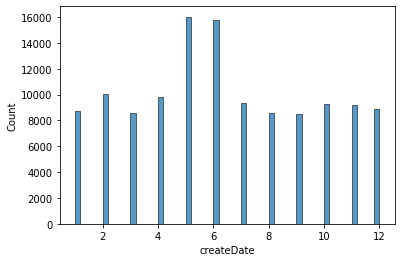

In [34]:
# see which month over the years has the most goals set
import seaborn as sns
df_goal=df_goal_copy
df_goal['createDate']=pd.to_datetime(df_goal['createDate'])
sns.histplot(pd.DatetimeIndex(df_goal['createDate']).month)

# Baseline Model

Let's pipe line up!

Preprocessing: 

- all numerical features: simimputer(median, because we have oustanding outliers) then Robustscaler for all numerical columns

- nice catogorical features: simpleinputer(mostfrequent) then OHE

- MiniBatichKmeans: play around with the number of clusters



In [150]:
from customerclustering.db_connection import Db
from customerclustering.get_training_data import *

In [151]:
import time
start_time = time.time()
# access to the data
conn = pymysql.connect(
    host=os.getenv('HOST'),
    port=int(3306),
    user=os.getenv('USER_DB'),
    passwd=os.getenv('PASSWORD_DB'),
    db=os.getenv('DB'),
    charset='utf8mb4')




rows=200000
df0=GetTrainingData(conn,rows).get_training_data()
df_copy=df0.copy()
print("--- %s seconds ---" % (time.time() - start_time))
df0.head()

/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


Getting activity features


/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


Getting queue features
Getting ratio of subs per user feature


/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


Getting CoP features


/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


Getting subscriber features


/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


Getting goal features
Returning a dataframe with 200000 rows
--- 300.26863503456116 seconds ---


,Product,Status,userID,stripeCustID,num_subs,account_age,pProfileID,typeOfPractice,located,specialities,...,RatioOfCompletion_num,RatioOfCompletion_min,event_cpd_day_diff,doc_in_activation,activated,plan_type,subscribe_days,GoalsPerYear,ratioOfAchivedGoals,metaGoalTitle
0,Ausmed Subscription,incomplete_expired,6037d38d-d098-4f68-be8c-49b7131b8116,cus_CVloz8uJiXpqfF,10,1616.0,41b3e81d-ccdd-40c8-b268-874344b0a1bf,hospital,remote area,"Rehabilitation,Aged care ,Medical",...,0.000000,0.000000,117.197044,10,1,quarterly,1546,5.0,0.4,"To gain confidence ,skills and knowledge as a ..."
1,Ausmed Subscription,canceled,62d1fe96-34f6-4992-9f15-b240f07770d8,cus_EoCO9ITZcMHmkA,9,1236.0,71a06b47-4762-49d2-b5fd-161c7ce6e1cd,hospital,large rural centre,Addiction and Substance Abuse,...,0.000000,0.000000,164.064103,2,1,quarterly,0,1.5,0.0,Do my best Gehenna d f r dwa wa daw daw
2,Ausmed Subscription,canceled,6e6b0e01-4a29-4724-a781-5d6a0d72a213,cus_BVqWWYIZ4tLhQr,6,2125.0,0cccdf89-bae9-4d06-8a40-81a6c7b3b7ce,GP Surgery,metropolitan centre,"Immunisation,Chronic Illness",...,0.111111,0.071138,149.362205,4,1,monthly,193,2.0,0.0,Covid vaccination and wound management. \nMy r...
3,Ausmed Subscription,active,33d2881f-8bc6-4b98-bafe-bfd20b141ee2,cus_AVUDPqhuPS9HRy,5,1948.0,72593341-edad-404e-9a92-bf7f576e5207,hospital,metropolitan centre,aged care; wound care and the continuity of he...,...,0.043478,0.013096,76.311787,2,1,quarterly,319,1.0,0.0,By the end of 2021 I would like to expand my k...
4,Ausmed Subscription,incomplete_expired,5f048ee3-4ea0-41e1-b859-c1cd9c95d80b,cus_F71ikWaGTyumEe,5,1186.0,752db353-5793-4636-acd7-fe3205291c91,Unemployed.,small rural centre,N/A,...,0.000000,0.000000,8.618321,4,1,quarterly,77,2.0,0.0,"Study, learn and retain knowledge. Do online s..."


In [153]:
# save the file and check
df0.to_csv("../raw_data/training_data.csv")
df1=pd.read_csv('../raw_data/training_data.csv',index_col=[0])
df1.head()

,Product,Status,userID,stripeCustID,num_subs,account_age,pProfileID,typeOfPractice,located,specialities,...,RatioOfCompletion_num,RatioOfCompletion_min,event_cpd_day_diff,doc_in_activation,activated,plan_type,subscribe_days,GoalsPerYear,ratioOfAchivedGoals,metaGoalTitle
0,Ausmed Subscription,incomplete_expired,6037d38d-d098-4f68-be8c-49b7131b8116,cus_CVloz8uJiXpqfF,10,1616.0,41b3e81d-ccdd-40c8-b268-874344b0a1bf,hospital,remote area,"Rehabilitation,Aged care ,Medical",...,0.000000,0.000000,117.197044,10,1,quarterly,1546,5.0,0.4,"To gain confidence ,skills and knowledge as a ..."
1,Ausmed Subscription,canceled,62d1fe96-34f6-4992-9f15-b240f07770d8,cus_EoCO9ITZcMHmkA,9,1236.0,71a06b47-4762-49d2-b5fd-161c7ce6e1cd,hospital,large rural centre,Addiction and Substance Abuse,...,0.000000,0.000000,164.064103,2,1,quarterly,0,1.5,0.0,Do my best Gehenna d f r dwa wa daw daw
2,Ausmed Subscription,canceled,6e6b0e01-4a29-4724-a781-5d6a0d72a213,cus_BVqWWYIZ4tLhQr,6,2125.0,0cccdf89-bae9-4d06-8a40-81a6c7b3b7ce,GP Surgery,metropolitan centre,"Immunisation,Chronic Illness",...,0.111111,0.071138,149.362205,4,1,monthly,193,2.0,0.0,Covid vaccination and wound management. \nMy r...
3,Ausmed Subscription,active,33d2881f-8bc6-4b98-bafe-bfd20b141ee2,cus_AVUDPqhuPS9HRy,5,1948.0,72593341-edad-404e-9a92-bf7f576e5207,hospital,metropolitan centre,aged care; wound care and the continuity of he...,...,0.043478,0.013096,76.311787,2,1,quarterly,319,1.0,0.0,By the end of 2021 I would like to expand my k...
4,Ausmed Subscription,incomplete_expired,5f048ee3-4ea0-41e1-b859-c1cd9c95d80b,cus_F71ikWaGTyumEe,5,1186.0,752db353-5793-4636-acd7-fe3205291c91,Unemployed.,small rural centre,NaN,...,0.000000,0.000000,8.618321,4,1,quarterly,77,2.0,0.0,"Study, learn and retain knowledge. Do online s..."


In [190]:
df1.isna().sum()/len(df1)

Product                     0.000000
Status                      0.000000
userID                      0.000000
stripeCustID                0.000000
num_subs                    0.000000
account_age                 0.098503
pProfileID                  0.000000
typeOfPractice              0.099171
located                     0.099038
specialities                0.099840
population                  0.099439
focus                       0.099439
complex                     0.099038
autonomy                    0.099038
access                      0.099038
country                     0.000000
hasPracticeRecord           0.000000
docPerYear                  0.000000
docOnAusmedPerYear          0.000000
minPerYear                  0.000000
minOnAusmedPerYear          0.000000
learnFromAusmedRatio_num    0.000000
learnFromAusmedRatio_min    0.000000
activityType                0.000000
secondFavActivityType       0.000000
numQueued                   0.000000
numCompletedFromQueue       0.000000
m

In [2]:
#base pipeline
import pandas as pd
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, OneHotEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn import set_config; set_config(display='diagram')
from sklearn.impute import SimpleImputer


# reindex df
df=pd.read_csv('../raw_data/training_data.csv')
df=df.set_index('userID')

# drop 'pProfileID' and 'stripeCustID' and Date columns
df.drop(columns=['pProfileID','stripeCustID'],inplace=True)

# select columns
# use all numerical columns
num_col=df.describe().columns
#do not include meta_title
cat_col=[col for col in df.columns if (col not in num_col)&(col!='metaGoalTitle') & (df[col].nunique()<5)]

# Robustscaler all numerical columns
num_transformer=make_pipeline(SimpleImputer(strategy='median'),RobustScaler()) 

#LabelEncoder all categorical columns
cat_transformer=make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder())


preproc=make_column_transformer((num_transformer,num_col),(cat_transformer,cat_col),remainder='drop')
#preproc.fit_transform(df)
preproc


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  Index(['Unnamed: 0', 'num_subs', 'account_age', 'hasPracticeRecord',
       'docPerYear', 'docOnAusmedPerYear', 'minPerYear', 'minOnAusmedPerYear',
       'learnFromAusmedRatio_num', 'learnF...
       'numCompletedFromQueue', 'minQueued', 'minCompleted',
       'RatioOfCompletion_num', 'RatioOfCompletion_min', 'event_cpd_day_diff',
       'doc_in_activation', 'activated', 'subscribe_days', 'GoalsPerYear',
       'ratioOfAchivedGoals'],
      dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['access', 'plan_type'])]))])

In [ ]:
from sklearn.preprocessing import RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn import set_config; set_config(display='diagram')
from sklearn.impute import SimpleImputer

# reindex df
df=pd.read_csv('../raw_data/training_data.csv')
#df=df.set_index('userID')



# # drop all nan
# df=df.dropna()
# # drop 'pProfileID' and 'stripeCustID' and Date columns
# df.drop(columns=['pProfileID','stripeCustID'],inplace=True)

# # select columns
# # use all numerical columns
# num_col=df.describe().columns
# #do not include meta_title
# cat_col=[col for col in df.columns if (col not in num_col)&(col!='metaGoalTitle')& (df[col].nunique()<5)]
# print(cat_col)

# # Robustscaler all numerical columns
# num_transformer=RobustScaler()

# #LabelEncoder all categorical columns
# cat_transformer=LabelEncoder()


# # Our first base pipeline-doesn't work
# preproc=make_column_transformer((num_transformer,num_col))#,(cat_transformer,cat_col))



# # # manually transform the numerical and categorical columns
# # ## numerical
# # df_num=pd.DataFrame(num_transformer.fit_transform(df[num_col]))
# # df_num.columns=num_col
# # df_num.head()

# # ## categorical
# # df_cat=df[cat_col].apply(cat_transformer.fit_transform)

# # df_processed=df_num
# # df_processed[cat_col]=df_cat
# # df_processed.head()

# # # reindex df by userID
# # df_processed.set_index(df['userID'],inplace=True)
# # df_processed

# # basepipe=make_pipeline(preproc,MiniBatchKMeans()) #shame on you!

# # basepipe

### Use Elbow Method to find the optimal cluster size

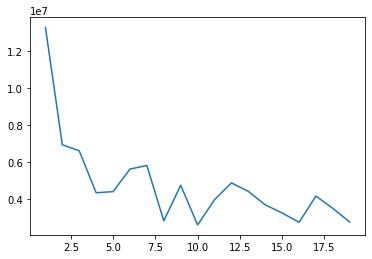

In [35]:
import matplotlib.pyplot as plt
# find the optimal n_cluster
df_processed=preproc.fit_transform(df)
# Apply the elbow method to find the optimal number of clusters.
wcss = []
clusters = list(range(1, 20))
# YOUR CODE HERE
for k in clusters:
    err=MiniBatchKMeans(n_clusters=k).fit(pf_processed).inertia_
    wcss.append(err)
    
# YOUR CODE HERE
plt.plot(clusters,wcss)

Looks like the optimal number of cluster is around 14, but should we go that far? Maybe 8 is enough?

# Visualization of the Basemodel Output

In [36]:
# The baseline model
print(f"The optimal cluster size is {clusters[wcss.index(min(wcss))]}") # this gives 14

base_model=MiniBatchKMeans(n_clusters=16)
X_pred=base_model.fit(df_processed).predict(df_processed)


The optimal cluster size is 10


In [38]:
# get centers
df_centers=pd.DataFrame(base_model.cluster_centers_)
#df_centers.columns=df_processed.columns
df_des=df_centers.describe()
df_des


,0,1,2,3,4,5,6,7,8,9,...,27588,27589,27590,27591,27592,27593,27594,27595,27596,27597
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,...,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,0.142905,-0.051962,-0.137625,0.411842,-0.037820,2.591889,0.529975,0.053590,0.069837,0.876676,...,0.000209,0.008852,0.004151,0.001403,0.009948,0.240826,0.440374,0.106097,0.237322,0.656581
std,0.056984,0.122127,0.117713,0.328610,0.327617,6.731216,0.483875,0.166538,0.210139,0.919903,...,0.000600,0.025086,0.004238,0.005069,0.009677,0.085258,0.109108,0.034645,0.090954,0.090763
min,0.038136,-0.361797,-0.476064,-0.079227,-0.657161,-0.112497,-0.082194,-0.313984,-0.378090,-0.131982,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.033898,0.233503,0.050926,0.107968,0.507614
25%,0.107195,-0.101649,-0.116273,0.226784,-0.198346,0.379321,0.263764,-0.075640,-0.077565,0.216720,...,0.000000,0.000000,0.000000,0.000000,0.001415,0.194772,0.381352,0.087300,0.172795,0.600170
50%,0.160053,-0.028811,-0.096173,0.343511,0.008192,0.500963,0.486139,0.110920,0.151067,0.841428,...,0.000000,0.000435,0.004374,0.000000,0.007990,0.259179,0.460334,0.103447,0.230261,0.656973
75%,0.177584,0.042548,-0.085147,0.522881,0.095707,1.173000,0.585410,0.169621,0.217820,1.187507,...,0.000000,0.003465,0.005402,0.000000,0.014385,0.314693,0.487005,0.123497,0.286758,0.724168
max,0.216573,0.132377,-0.050903,1.057202,0.861819,27.308859,1.911980,0.238290,0.299299,3.691219,...,0.002372,0.100372,0.015094,0.020305,0.031599,0.345178,0.678191,0.195167,0.395939,0.805851


In [ ]:
df_des.loc['std',:].sort_values(ascending=False)


Text(0.5, 0.92, 'simple 3D scatter plot')

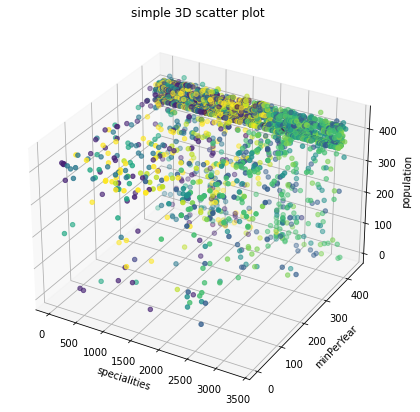

In [107]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


# Choose the columns have large std from the describe table
x=df_processed.specialities
y=df_processed.typeOfPractice
z=df_processed.population

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
# Creating plot
ax.scatter3D(x, y, z, c = X_pred)
ax.set_xlabel('specialities')
ax.set_ylabel('minPerYear')
ax.set_zlabel('population')
plt.title("simple 3D scatter plot")

## Test baseline.py

In [95]:
from customerclustering.baseline import *

In [122]:
df1=pd.read_csv('../raw_data/training_data.csv',index_col=[0])

baseline=Baseline(df1,n_cluster=11).run()

model.joblib saved locally


# Feature engineering


- minPerYear                        

- specialities                        

- population                            

- typeOfPractice                        
- minCompleted- filter out >=150, then RobustScaler()

- focus                                  
- 2ndFavActivityType                    
- favActivityType                        
- complex                                
- access                                 

## Troubleshoot MinPerYear (drop this feature)

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df=pd.read_csv('../raw_data/training_data.csv',index_col=[0])
nrow=200000
df_act=pd.read_sql_query(f"SELECT * FROM activity_20220808 LIMIT {nrow};", conn).drop_duplicates()
df_evt=pd.read_sql_query("SELECT * FROM tracking_event;", conn).drop_duplicates()
df_act_copy=df_act
df_evt_copy=df_evt

/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


(0.0, 200000000.0)

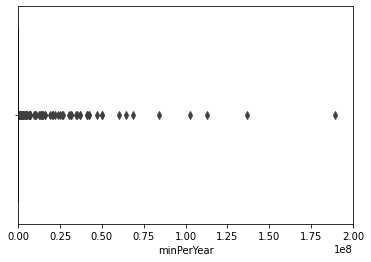

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.boxplot(x=df.minPerYear)
plt.xlim(0,0.2e9)

In [24]:
# get strange MinPerYear
df_strange=df[(df.minPerYear<0) | (df.minPerYear>0.2e9) ][['userID','minPerYear','account_age']]
df_strange

,userID,minPerYear,account_age
316,7556c09f-e6fa-4d78-b3cc-03b3803cb861,1.704075e+10,896.0
508,e001c4b1-bed4-4c69-97b0-e33f77c9ee22,-1.033053e+01,1497.0
581,008b0d78-1d06-4247-a39d-84fd86ae7637,4.102404e+08,584.0
691,059f3739-e729-4c85-98fa-a631a85505e8,-7.790379e+02,1562.0
874,0db8e835-4312-4c74-b19a-5935f6d7ffe9,-1.901193e+01,1610.0
964,11ae8539-f146-4d71-b2e1-bc515a122ae9,-1.217718e+01,1954.0
965,11b25805-5c90-482e-89ab-c9a647106bdd,-2.569708e+01,2006.0
1264,2080c5b3-b01a-40ba-8b69-fb796984b841,-2.388875e+01,1560.0
1375,25bfaf93-2b45-46f5-85d1-f5e25a44989e,-3.836636e+02,2007.0
1769,369902cd-133b-4880-982a-f76890cccedd,-6.267109e+01,1646.0


/var/folders/bh/j223y_td6s35mkxwj_m8bxdm0000gn/T/ipykernel_86019/3070009741.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_evt.rename(columns={'resourceID':'resource'},inplace=True)


In [15]:
df_act.describe()

,minOnAusmed,minPerYear,percentageOfLearningFromAusmed
count,65617.000000,6.561700e+04,65617.000000
mean,24.556655,1.434287e+08,0.301264
std,116.276423,2.048561e+09,0.430736
min,0.000000,5.904582e-02,0.000000
25%,0.000000,1.274257e+01,0.000000
50%,0.000000,1.262447e+02,0.000000
75%,17.000000,1.314873e+07,0.920000
max,18030.000000,3.155695e+11,1.000000


## 'minCompleted'

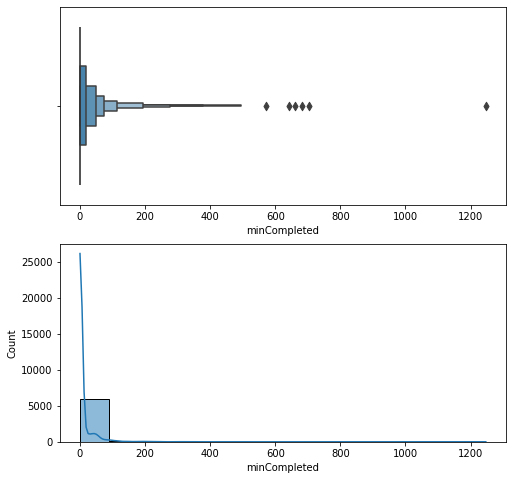

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
#fig, axplt.subplots
fig, ax = plt.subplots(2, figsize=(8,8))
sns.boxenplot(x=df.minCompleted,ax=ax[0])

sns.histplot(x=df.minCompleted,kde=True,ax=ax[1])


plt.show()


In [20]:
# get the fraction of outliers
len([df[df['minCompleted']>=150]])/len(df)

0.00016315875346712352

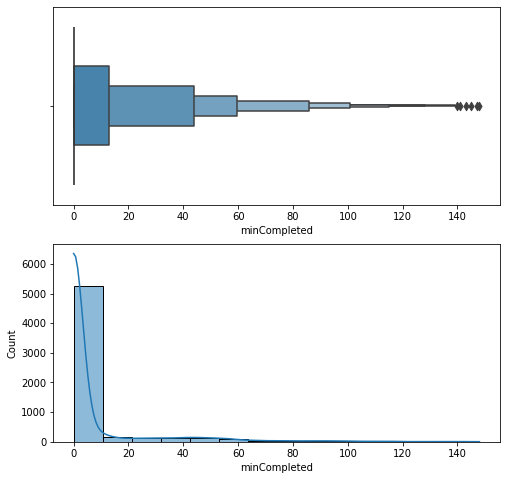

In [59]:
# plot filtered minComplted
import matplotlib.pyplot as plt
import seaborn as sns
#fig, axplt.subplots
df_f1=df[df['minCompleted']<150]
fig, ax = plt.subplots(2, figsize=(8,8))
sns.boxenplot(x=df_f1.minCompleted,ax=ax[0])

sns.histplot(x=df_f1.minCompleted,kde=True,ax=ax[1])


plt.show()


## Population

In [14]:
df=pd.read_csv('../raw_data/training_data.csv',index_col=[0])

In [16]:
# check missing values
df.population.isna().sum()/len(df1)

0.0004894762604013706

In [20]:
df.describe().columns

Index(['num_subs', 'account_age', 'yearsOnAusmed', 'min', 'minOnAusmed',
       'minOnAusmedPerYear', 'minPerYear', 'percentageOfLearningFromAusmed',
       'numQueued', 'numCompletedFromQueue', 'minQueued', 'minCompleted',
       'RatioOfCompletion_num', 'RatioOfCompletion_min', 'event_cpd_day_diff',
       'doc_in_activation', 'activated', 'subscribe_days', 'GoalsPerYear',
       'ratioOfAchivedGoals'],
      dtype='object')

# Get Outliers



In [43]:
df=pd.read_csv('../raw_data/training_data.csv',index_col=[0])

num_subs


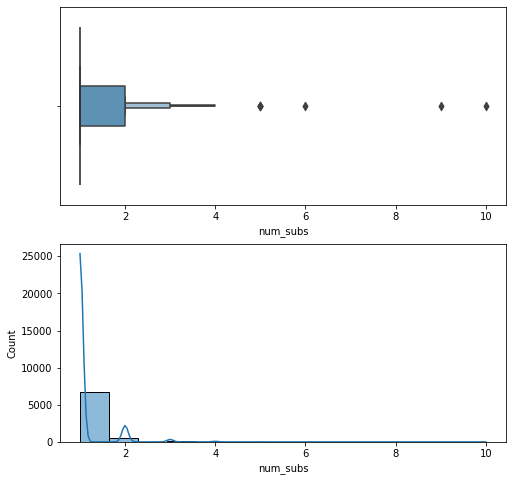

account_age


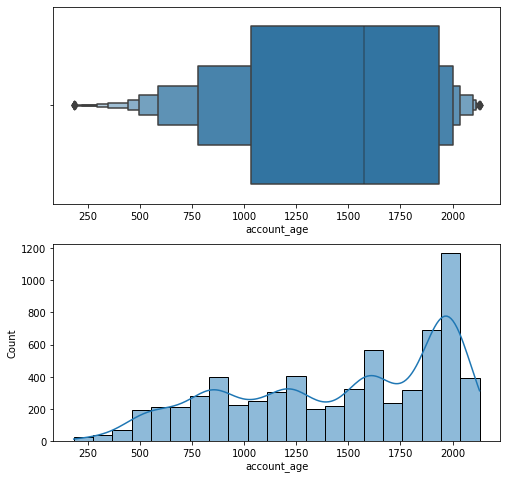

hasPracticeRecord


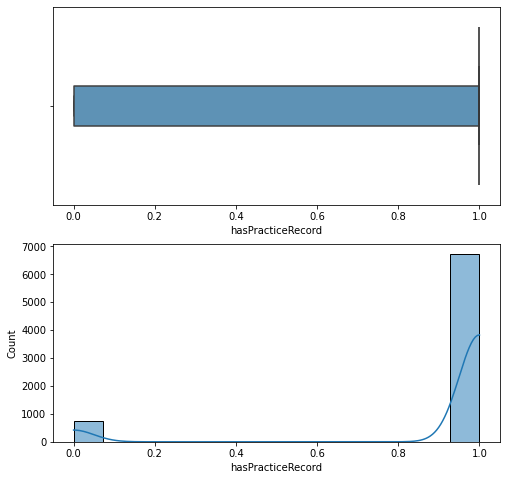

docPerYear


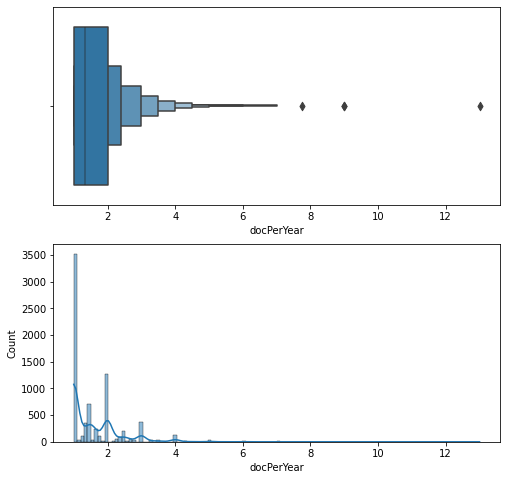

docOnAusmedPerYear


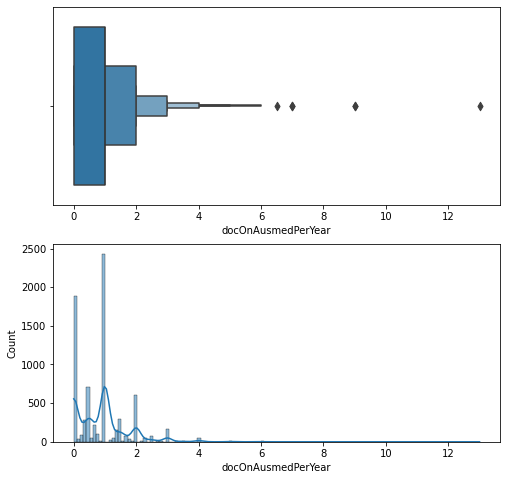

learnFromAusmedRatio_num


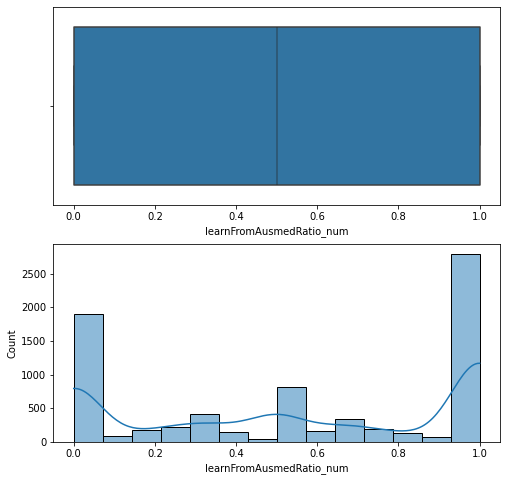

learnFromAusmedRatio_min


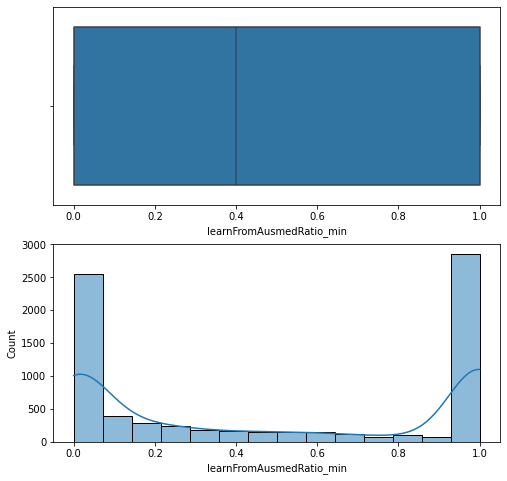

numQueued


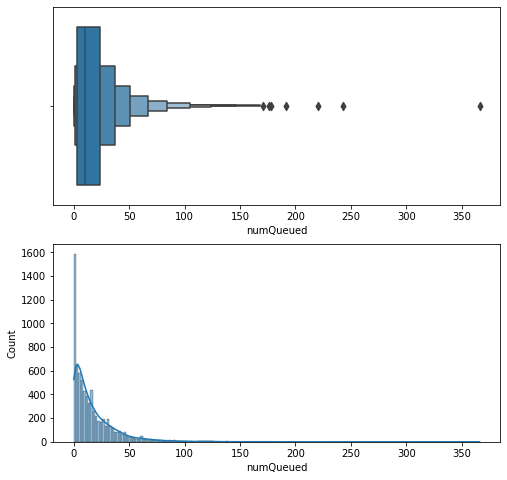

numCompletedFromQueue


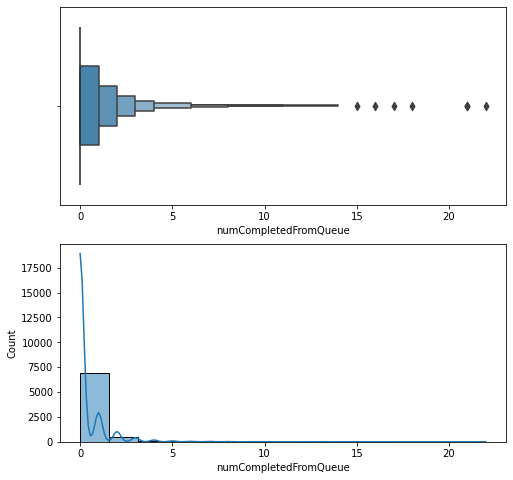

minQueued


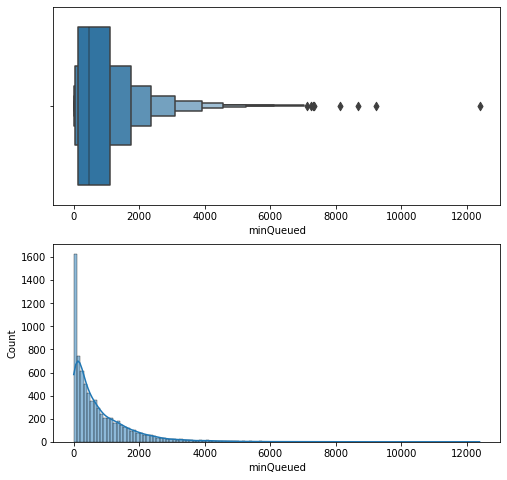

minCompleted


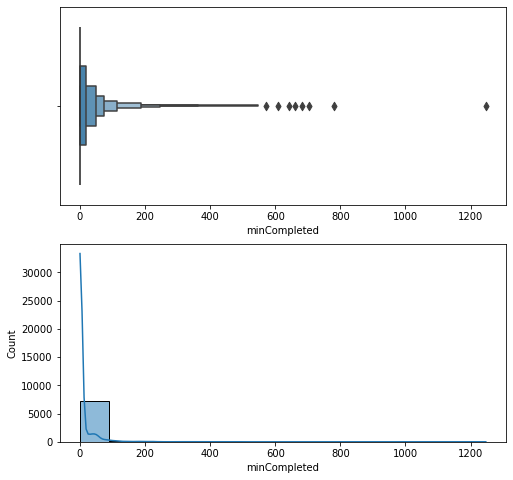

RatioOfCompletion_num


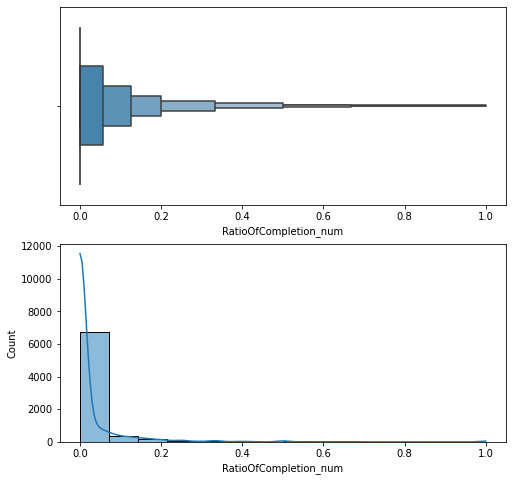

RatioOfCompletion_min


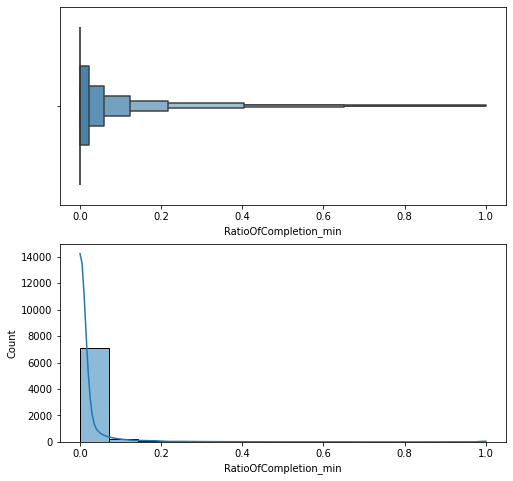

event_cpd_day_diff


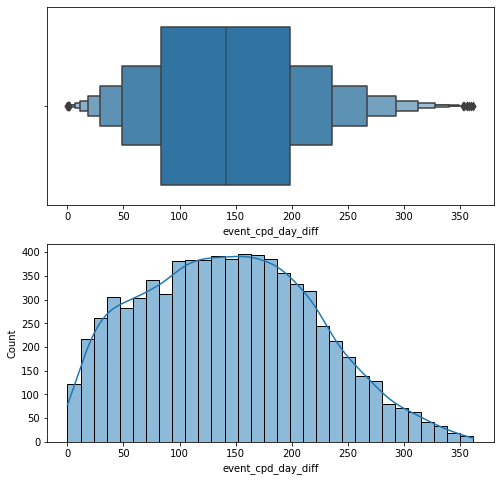

doc_in_activation


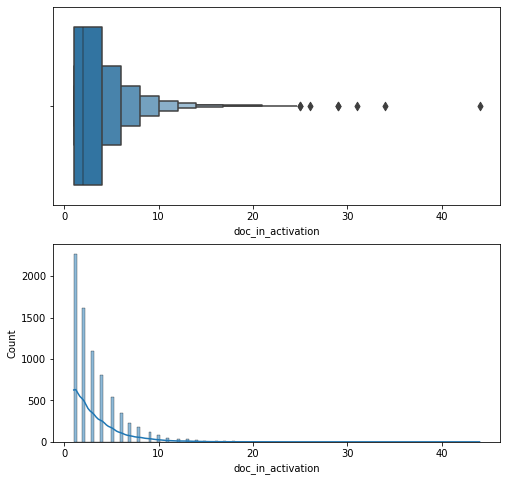

activated


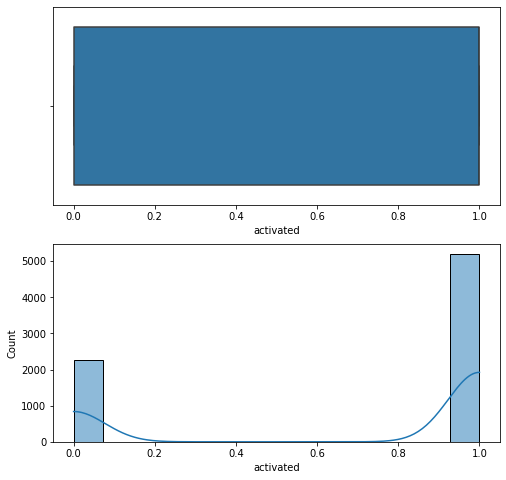

subscribe_days


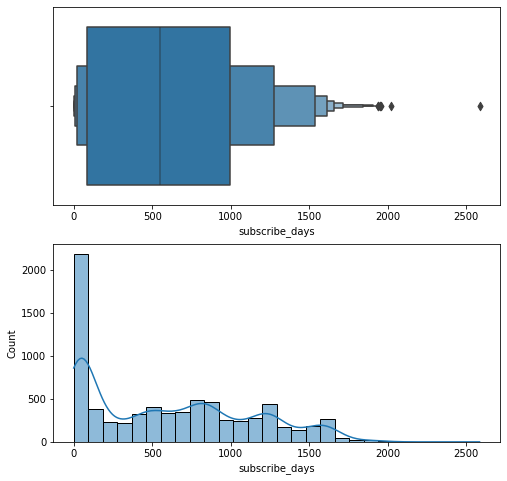

GoalsPerYear


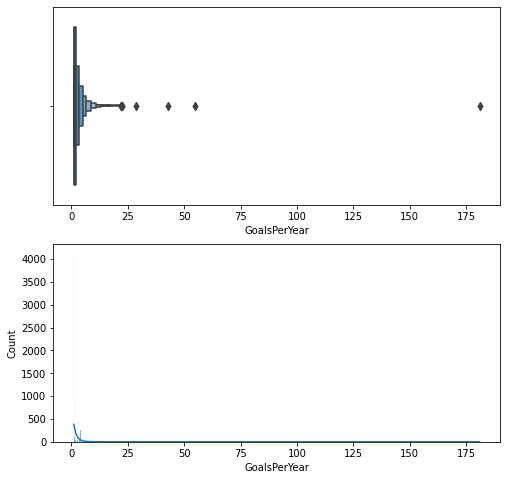

ratioOfAchivedGoals


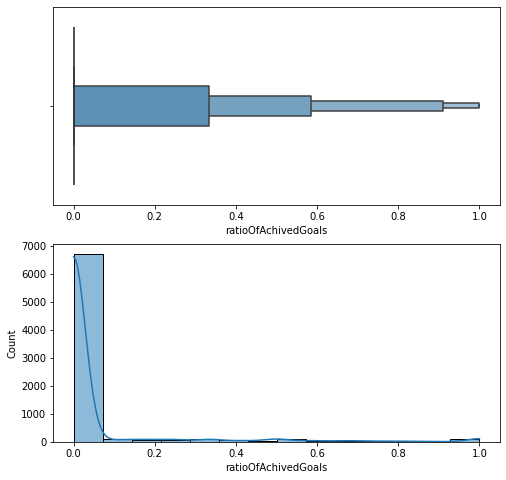

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
col_not_inuse=['minPerYear','minOnAusmedPerYear']
col_inuse=[feature for feature in  df.describe().columns if feature not in col_not_inuse]

for feature in col_inuse:
    print(feature)
    fig, ax=plt.subplots(2, figsize=(8,8))
    sns.boxenplot(x=df[f'{feature}'],ax=ax[0])
    sns.histplot(x=df[f'{feature}'],kde=True,ax=ax[1])
    plt.show()




In [68]:
# clean the data
#outliers are from 'docPerYear','docOnAusmedPerYear','numQueued','minQueued','minCompleted','GoalsPerYear'
import numpy as np
from scipy import stats

#df[(np.abs(stats.zscore(df[num_col])) >10).all(axis=1)]
#df[(np.abs(stats.zscore(df[num_col])) <10).all(axis=1)]

threshold=1-0.001
df.quantile(1-threshold)
num_otl=['docPerYear','docOnAusmedPerYear','numQueued','minQueued','minCompleted','GoalsPerYear']

thr_dpy=df.docPerYear.quantile(threshold)
thr_dapy=df.docOnAusmedPerYear.quantile(threshold)
thr_nq=df.numQueued.quantile(threshold)
thr_mq=df.minQueued.quantile(threshold)
thr_mc=df.minCompleted.quantile(threshold)
thr_gpy=df.GoalsPerYear.quantile(threshold)

df_cleaned=


num_subs                       3.000000
account_age                 2118.000000
hasPracticeRecord              1.000000
docPerYear                     4.666667
docOnAusmedPerYear             4.000000
minPerYear                  3040.761000
minOnAusmedPerYear           239.510667
learnFromAusmedRatio_num       1.000000
learnFromAusmedRatio_min       1.000000
numQueued                    109.266000
numCompletedFromQueue          6.000000
minQueued                   4675.798000
minCompleted                 196.899000
RatioOfCompletion_num          0.500000
RatioOfCompletion_min          0.443178
event_cpd_day_diff           330.232100
doc_in_activation             14.000000
activated                      1.000000
subscribe_days              1742.165000
GoalsPerYear                  11.500000
ratioOfAchivedGoals            1.000000
Name: 0.993, dtype: float64

# The model

In [11]:
from sklearn.preprocessing import RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn import set_config; set_config(display='diagram')
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

df=pd.read_csv('../raw_data/training_data.csv',index_col=[0])
# select columns
# use all numerical columns
num_col=df.describe().columns
#do not include meta_title
cat_col=[col for col in df.columns if (col not in num_col)&(col!='metaGoalTitle')]

# Robustscaler all numerical columns
num_transformer=make_pipeline(SimpleImputer(strategy='median'),RobustScaler()) 

#LabelEncoder all categorical columns
cat_transformer=make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder())


preproc=make_column_transformer((num_transformer,num_col),(cat_transformer,cat_col),remainder='drop')


<AxesSubplot:>

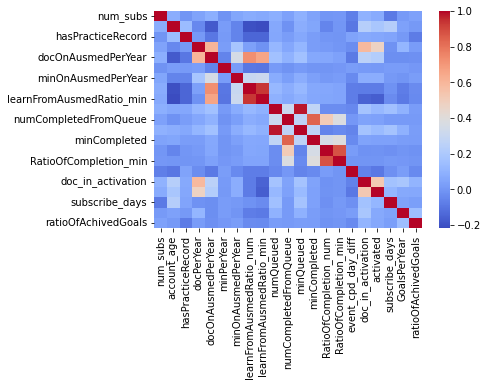

In [12]:
import seaborn as sns
sns.heatmap(df.corr(), cmap='coolwarm')

In [13]:
# feature selection with PCA 

# get principal component 

# project the data on the components

# Kmean on the projected data


# let's work on the numerical data first

df_num=df[num_col]
df_num_processed=num_transformer.fit_transform(df_num)
pca=PCA()
pca.fit(df_num_processed)
#df_num.head()


PCA()

In [15]:
# Access our PCs 
W = pca.components_

# Print PCs as COLUMNS
W = pd.DataFrame(W.T,
                 index=num_col,
                 columns=[f'PC{i}' for i in range(1, len(num_col)+1)])
W

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
num_subs,0.000411,-0.000397,0.002144,0.019492,-0.027243,0.014128,0.001265,-0.058796,0.043550,0.033310,...,0.039725,0.935172,0.138690,-0.013350,-0.002999,0.014749,0.014374,0.000074,-0.002253,-0.000318
account_age,0.000724,0.000767,0.010312,-0.020892,-0.048893,0.037664,0.347449,-0.243294,-0.104628,-0.357401,...,-0.616473,-0.155989,0.098970,0.062546,-0.020969,-0.010123,0.008194,-0.000238,-0.005628,-0.001777
hasPracticeRecord,0.000171,0.000348,0.001309,-0.010244,-0.017447,0.003209,0.053622,0.024137,-0.004101,-0.007035,...,-0.058019,-0.013826,0.010703,-0.992404,-0.034419,-0.077620,0.014247,0.000363,-0.004743,0.000933
docPerYear,0.000454,0.001505,0.037683,0.165936,-0.174864,0.526726,-0.116731,0.159464,0.035233,0.300700,...,-0.459647,0.058728,0.246211,0.041625,-0.405254,-0.033743,-0.002728,-0.013238,-0.089227,-0.000008
docOnAusmedPerYear,0.001312,-0.003897,-0.004395,0.265766,-0.127896,0.315394,-0.605901,-0.130896,-0.152026,-0.156510,...,-0.112027,-0.025373,-0.024252,-0.048751,0.584482,0.020758,0.005371,0.019753,0.129840,-0.000104
minPerYear,-0.001979,0.999963,-0.004305,-0.001267,0.000281,0.000984,-0.005707,-0.002292,-0.000139,-0.002006,...,0.001529,-0.000160,-0.000683,-0.000060,-0.000303,-0.000026,0.000004,-0.000025,0.000275,-0.000021
minOnAusmedPerYear,0.001424,0.002673,-0.004590,0.910940,0.289447,-0.190054,0.212107,0.049839,0.038559,0.029021,...,-0.002395,-0.002705,0.006362,-0.003062,0.003779,0.003300,0.000849,-0.001433,-0.006879,-0.000104
learnFromAusmedRatio_num,0.000600,-0.003032,-0.011178,0.095716,-0.013949,-0.005800,-0.317149,-0.139232,-0.109583,-0.221448,...,0.175645,-0.050761,-0.094406,-0.013246,-0.307393,-0.008207,0.003271,-0.139418,-0.789766,-0.000060
learnFromAusmedRatio_min,0.000615,-0.003604,-0.014152,0.102176,0.003142,-0.033746,-0.338478,-0.153567,-0.118929,-0.218157,...,0.185023,-0.061026,-0.022073,-0.007480,-0.622219,-0.044331,-0.001992,0.094684,0.565725,-0.000138
numQueued,0.006722,0.001098,0.041589,0.130920,-0.635745,-0.308745,0.003380,0.046418,0.018690,0.065268,...,-0.003816,-0.031237,0.012364,0.019020,-0.003743,0.018959,0.686260,0.041108,-0.004149,-0.015466


In [17]:
df_num_proj = pca.transform(df_num_processed)
df_num_proj = pd.DataFrame(df_num_proj, columns=[f'PC{i}' for i in range(1, len(num_col)+1)])
df_num_proj

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
0,-9.806203,1.592952,3.150050,1.729012,-0.400984,2.380240,0.357499,-0.962604,0.024094,-0.558933,...,0.848008,8.319045,1.435559,-0.234023,0.559120,-0.137045,0.107272,-0.075252,-0.309482,-0.001445
1,-9.813381,-1.340475,-0.575031,0.899743,0.482252,0.719647,-1.238018,-0.443574,0.114146,0.541045,...,0.076677,7.329144,0.706581,-0.281713,-0.030586,0.129164,0.105270,-0.018706,0.028852,0.001526
2,25.198361,-0.971979,-0.074037,-0.573852,0.426160,0.349882,0.835512,-0.266364,0.368332,0.209227,...,-0.129154,4.399277,0.449890,-0.098992,-0.014361,0.122106,0.008391,0.071501,0.032403,-0.017825
3,15.247933,-1.553274,-1.006254,0.222286,-1.618727,-1.033943,-0.404577,-0.477137,1.246154,-0.515015,...,-0.120030,3.393416,0.102595,-0.129536,-0.235582,0.076153,0.098457,-0.042501,0.006988,0.016905
4,-9.799814,-0.756775,0.021644,2.448950,-0.360428,0.251889,-0.663100,-1.191370,0.663998,0.695266,...,0.345225,3.449543,0.295973,-0.255284,0.015622,0.101032,-0.107063,-0.005976,0.033537,0.003281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7477,-9.810800,-1.670460,-1.028502,0.004767,-0.266019,0.223782,-0.801523,-0.281119,-0.240562,-0.100506,...,0.295897,-0.068705,-0.425892,-0.166944,-0.089974,0.023818,-0.013435,-0.009779,0.037467,0.002454
7478,-9.821442,-1.263250,-1.018629,-1.100152,0.415126,0.330886,1.021068,-0.045354,0.336527,0.491257,...,-0.181334,-0.246288,-0.237332,-0.038113,0.026670,0.046475,-0.007415,-0.001029,0.085020,0.002918
7479,-9.806160,3.777157,-1.188514,11.569067,4.099802,-3.166340,2.309392,0.221130,-0.036772,-0.419735,...,-0.233431,-0.203510,0.519445,-0.148915,-0.102127,0.036575,-0.096029,-0.051469,-0.127479,0.002011
7480,-9.819413,-1.139534,0.956900,-1.010673,0.662777,0.397323,0.603440,-0.082913,0.243852,0.345662,...,-0.075517,-0.212148,-0.296724,-0.074651,0.141916,0.070659,0.072015,-0.027349,-0.052924,0.001890


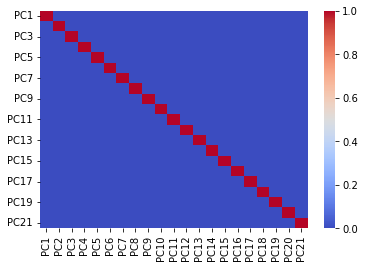

In [18]:
sns.heatmap(df_num_proj.corr(), cmap='coolwarm');

(0.0, 200.0)

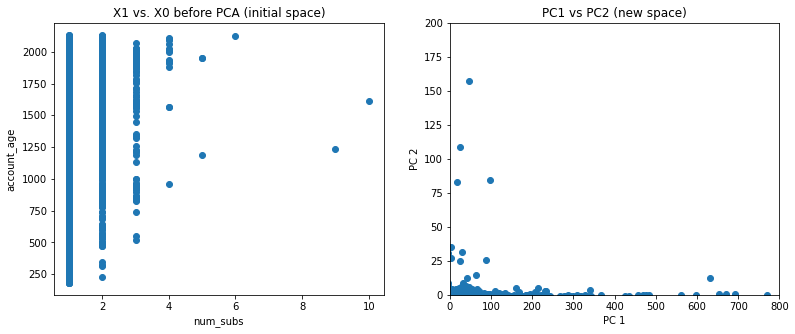

In [21]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.title('X1 vs. X0 before PCA (initial space)'); plt.xlabel(f'{df_num.columns[0]}'); plt.ylabel(f'{df_num.columns[1]}')
plt.scatter(df_num.iloc[:,0], df_num.iloc[:,1])

plt.subplot(1,2,2)
plt.title('PC1 vs PC2 (new space)'); plt.xlabel('PC 1'); plt.ylabel('PC 2')
plt.scatter(df_num_proj.iloc[:,0], df_num_proj.iloc[:,1]);
plt.xlim(0,800)
plt.ylim(0,200)

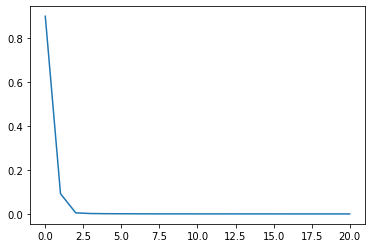

In [41]:
# to get the number of components to use
plt.plot(pca.explained_variance_ratio_)


In [42]:
df.specialities.

0                      Rehabilitation,Aged care ,Medical 
1                           Addiction and Substance Abuse
2                            Immunisation,Chronic Illness
3       aged care; wound care and the continuity of he...
4                                                     NaN
                              ...                        
7477                                Residential Aged Care
7478                           Wound care,Palliative care
7479                        Respiratory,Diabetes Mellitus
7480                                 Extended Day Surgery
7481                                Residential Aged Care
Name: specialities, Length: 7482, dtype: object

## Interesting Exploration

array(['e-Learning'], dtype=object)

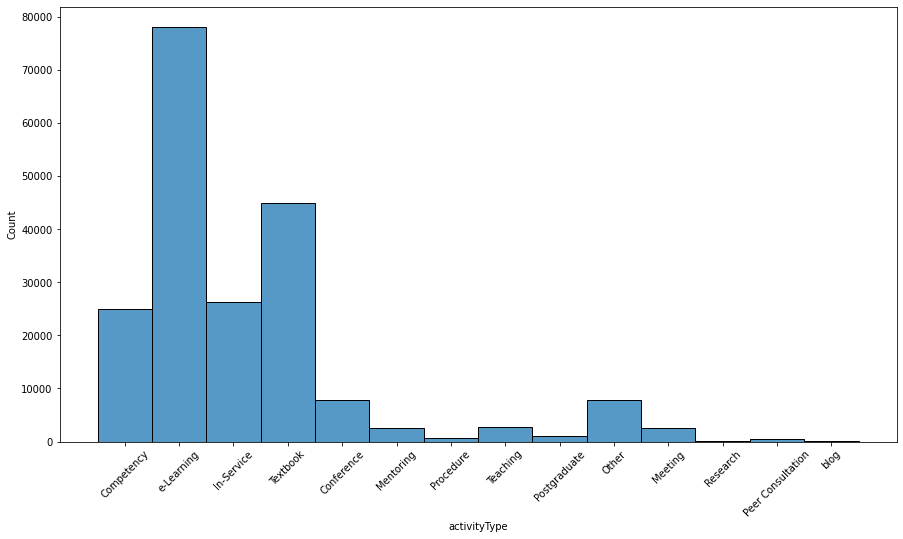

In [22]:
# exploring the distribution of activityType
import matplotlib.pyplot as plt
import seaborn as sns
df_act=df_act_copy
plt.figure(figsize = (15,8))
ax =sns.histplot(df_act['activityType'])
plt.xticks(rotation=45)

